In [2]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size

## Load installed packages

In [3]:
packages = pd.read_csv('../data/cleaned_installed_packages.csv')
packages.package.fillna('nan', inplace=True)
packages['last_updated'] = pd.to_datetime(packages['last_updated'])
packages.rename(columns = {'operating':'os'}, inplace=True)
len(packages)

998727

In [4]:
packages.query('package == "assert"').image.unique().size

20

In [5]:
npm = pd.read_csv('../data/npm_versions.csv', dtype=str)
python = pd.read_csv('../data/pypi_versions.csv', dtype=str)
ruby = pd.read_csv('../data/ruby_versions.csv', dtype=str)
available = pd.concat([npm, python, ruby])
available.package.fillna('nan', inplace=True)

packages = packages[packages.package.isin(available.package)]

In [6]:
# Filter on 3000 images
candidates_3000 = pd.read_csv('../data/considered_3000_images.csv')
mask = packages.image.isin(candidates_3000.image)
packages = packages[mask]
packages['base'] = packages['base'].replace(d)
len(packages)

816151

### RQ1_ Filter on which images to analyze (Ignore "Ubuntu" images since there are not many)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


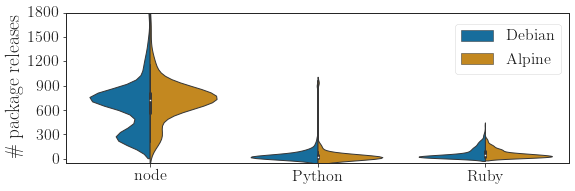

In [7]:
# Number of packages installed in an image (all packages, even duplicated)
df_tmp = packages.groupby(['image','base','os']).count()[['package']].reset_index()
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
df_tmp['base'] = df_tmp['base'].replace(d)
fig.set_size_inches(9,2.76)
ax = sns.violinplot(x="base", 
                 y="package",
                   hue='os',
                 order = order,
                 data=df_tmp, 
                 linewidth=1,
                    split=True,
                  )
ax.set(
    xlabel='',
    ylabel='\# package releases',# releases',
    ylim=(-50,1801)
)
plt.yticks(pd.np.arange(0, 1801, 300)) 
ax.legend(bbox_to_anchor= (1,0.98))

In [8]:
print(df_tmp.groupby(['base'])['package'].describe().drop(['std','count','25%', '75%'], axis=1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &    min &    50\% &     max \\
base   &          &        &        &         \\
\midrule
Python &   45.288 &    1.0 &   17.0 &   939.0 \\
Ruby   &   65.372 &    7.0 &   42.0 &   410.0 \\
node   &  705.491 &  127.0 &  717.0 &  5129.0 \\
\bottomrule
\end{tabular}



In [9]:
df_tmp.query('package == 5129.0').image.values

array(['ataylorme/docker-node-advanced-wordpress-on-pantheon'],
      dtype=object)

In [10]:
# Mann-whitney u test
for base in order:
    print(base,scipy.stats.mannwhitneyu(df_tmp.query('base =="'+base+'" and os=="Alpine"').package,
                                  df_tmp.query('base =="'+base+'" and os=="Debian"').package))

node MannwhitneyuResult(statistic=94253.0, pvalue=2.6497673983403312e-09)
Python MannwhitneyuResult(statistic=97125.5, pvalue=2.92981561774232e-09)
Ruby MannwhitneyuResult(statistic=89254.5, pvalue=0.10375613952121143)


In [11]:
# Effect size
for base in order:
    print(base, effect_size.cliffsDelta(df_tmp.query('base =="'+base+'" and os=="Alpine"').package,
                      df_tmp.query('base =="'+base+'" and os=="Debian"').package))

d=0.2164877322925629
node True
d=-0.21382606724838515
Python True
d=0.05298255665902725
Ruby False


In [12]:
len(packages)

816151

In [13]:
# Duplicated package releases
len(packages.query('base== "node"').drop_duplicates())/len(packages.query('base== "node"'))

0.5287168794499151

In [14]:
# Top packages that are duplicated
(packages.groupby(['image','package','version'])
 .count()[['version_release']]
 .query('version_release>1')
 .reset_index()
 [['image','package']].drop_duplicates()
 .groupby(['package'])
 .count()[['image']]
 .sort_values('image', ascending=False)
 .head(10)
)

image
package                       
glob                       998
core-util-is               989
minimatch                  963
readable-stream            928
once                       855
is-fullwidth-code-point    850
string-width               850
code-point-at              843
console-control-strings    843
npmlog                     838

## Many packages will have the same dependencies. Let's remove duplicates

In [15]:
packages.drop_duplicates(inplace=True)
len(packages)

483585

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


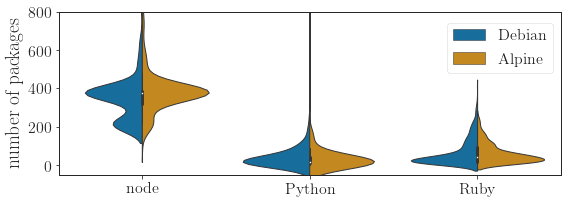

In [18]:
# Number of packages installed in an image (all packages without duplicated)
df_tmp = packages.groupby(['image','base','os']).count()[['package']].reset_index()
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
df_tmp['base'] = df_tmp['base'].replace(d)
fig.set_size_inches(9,3)
ax = sns.violinplot(x="base", 
                 y="package",
                   hue='os',
                 order = order,
                 data=df_tmp, 
                 linewidth=1,
                    split=True,
                  )
ax.set(
    xlabel='',
    ylabel='number of packages',
    ylim=(-50,801)
)
plt.yticks(pd.np.arange(0, 801, 200)) 
ax.legend(bbox_to_anchor= (1,0.98))

In [19]:
print(df_tmp.groupby(['base'])['package'].describe().drop(['count','std','25%', '75%'], axis=1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &    min &    50\% &     max \\
base   &          &        &        &         \\
\midrule
Python &   45.208 &    1.0 &   17.0 &   939.0 \\
Ruby   &   65.372 &    7.0 &   42.0 &   410.0 \\
node   &  373.005 &  101.0 &  377.0 &  1401.0 \\
\bottomrule
\end{tabular}



In [20]:
# Mann-whitney u test
for base in order:
    print(base,scipy.stats.mannwhitneyu(df_tmp.query('base =="'+base+'" and os=="Alpine"').package,
                                  df_tmp.query('base =="'+base+'" and os=="Debian"').package))

node MannwhitneyuResult(statistic=96398.0, pvalue=4.232915487513389e-08)
Python MannwhitneyuResult(statistic=97135.5, pvalue=2.9686983031743786e-09)
Ruby MannwhitneyuResult(statistic=89254.5, pvalue=0.10375613952121143)


In [21]:
# Effect size
for base in order:
    print(base, effect_size.cliffsDelta(df_tmp.query('base =="'+base+'" and os=="Alpine"').package,
                      df_tmp.query('base =="'+base+'" and os=="Debian"').package))

d=0.1986566413539991
node True
d=-0.2137451231160253
Python True
d=0.05298255665902725
Ruby False


In [22]:
tmp_df = (packages
 .groupby(['image','base','package'])
 .count()[['version']]
 .reset_index()
 .sort_values('version', ascending=False)
 .query('version>1')
)
tmp_df.groupby('base').head()

image    base       package  version
2204                    a114m/dihlab-sails    node        lodash        8
262281                mradochonski/sailsjs    node         async        8
385304                strongloop/strong-pm    node         debug        8
414786         ttssdev/strong-confd-parser    node         debug        8
328864                   rethinkdb/horizon    node          glob        8
83461                            cwds/cans    Ruby          rake        3
372308      snappler/docker-stats-exporter    Ruby       bundler        3
83455                            cwds/cans    Ruby         rails        3
83459                            cwds/cans    Ruby      railties        3
351433      saorio/circleci_codenize_tools    Ruby          json        3
359289      sdcplatform/respondent-home-ui  Python           six        2
359316  sdcplatform/response-operations-ui  Python  cryptography        2
359226               sdcplatform/rasrm-ops  Python          idna        2
359200               sdcplatform/ras-party  Python           six        2
359269      sdcplatform/respondent-home-ui  Python          idna        2

In [23]:
tmp_df[['package','base']].drop_duplicates().groupby('base').count()

package
base           
Python       15
Ruby        190
node        862

In [24]:
tmp_df[['package','base']].drop_duplicates().groupby('base').count()/packages[['package','base']].drop_duplicates().groupby('base').count()

package
base            
Python  0.003879
Ruby    0.059043
node    0.168261

In [28]:
tmp_df[['image','base']].drop_duplicates().groupby(['base']).count()

image
base         
Python     13
Ruby      521
node     1000

In [32]:
df = pd.read_csv('../data/installed_packages.csv')
df.drop_duplicates(inplace=True)
df ['base2'] = df ['base'].apply(lambda x: 'P'+x[1:-1])
mask = (df.base2+df.package).isin(tmp_df.query('base=="Python"').base+tmp_df.query('base=="Python"').package)
df = df[mask]
df[['image','package','version','base']].groupby(['image','package','version']).count().sort_values('version')

base
image                        package        version      
gw20e/jessie-py3.6.0-nodejs  pyasn1         0.1.7       1
aishwaryashinde/add          pyasn1         0.1.7       1
chrisramsay/aws-gen          pyasn1         0.1.7       1
driveclutch/circleci-python  pyasn1         0.1.7       1
macadmins/crypt-server-saml  pyasn1         0.1.8       1
...                                                   ...
kwikee/bapi-be               more-itertools 8.0.2       1
renku/renku-demo             more-itertools 8.0.2       1
pretix/standalone            more-itertools 8.0.2       1
drillinginfo/cloud-custodian more-itertools 8.0.2       1
mozilla/addons-server        more-itertools 8.0.2       1

[6169 rows x 1 columns]

In [16]:
packages[packages.package.str.contains('virtualenv')].image.unique().size

181

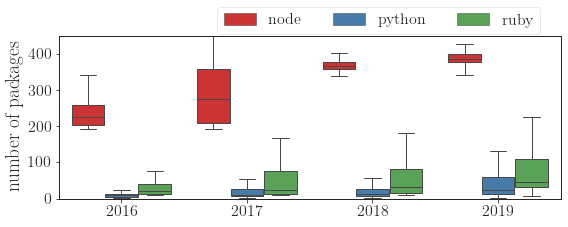

In [212]:
# ALL packages, by year
df_tmp = (packages
          .groupby(['image','base','last_updated','os'])
          .count()[['package']]
          .reset_index()
         )
df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,3)
ax = sns.boxplot(x="year", 
                 y="package",
                   hue='base',
                 hue_order = order,
                 data=df_tmp, 
                 palette='Set1', 
                 linewidth=1,
                 showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of packages',
    ylim=(0,451)
)
#ax.set_yscale('log')
ax.legend(bbox_to_anchor= (0.3, 0.96), ncol=3)
#plt.yticks(pd.np.arange(0, 301, 60)) 
